In [1]:
import pandas as pd       # Data handling (e.g., price data, returns)
import numpy as np        # Numerical operations (e.g., mean, standard deviation)
import backtrader as bt  # Full-featured backtesting framework
from finta import TA    # Technical Analysis library (e.g., moving averages, RSI)
import QuantLib as ql   # Quantitative finance models, pricing, and calculations

import matplotlib.pyplot as plt   # Plotting results like returns or drawdowns
import seaborn as sns             # Enhanced visualizations (optional)
from scipy.stats import norm      # Used for probability calculations in finance
import quantstats
import riskfolio as rp
import yfinance as yf

In [2]:
ticker = "AAPL"  # Symbol for NIFTY50 index

# Fetch data using yfinance
data = yf.download(
    tickers=ticker,
    # interval="5m",       # 5-minute timescale
    period="1y",         # Maximum period available for 5-minute data
    progress=False       # To suppress download progress
)
data.columns = data.columns.droplevel(1)
data

Price,Close,High,Low,Open,Volume
Date,,,,,
2024-01-09,184.237411,184.247357,181.839157,183.023358,42841800
2024-01-10,185.282303,185.491271,183.023365,183.451277,46792900
2024-01-11,184.685196,186.138085,182.724799,185.630561,49128400
2024-01-12,185.013596,185.829605,184.287159,185.152912,40444700
2024-01-16,182.734787,183.361705,180.047938,181.271952,65603000
...,...,...,...,...,...
2025-01-02,243.850006,249.100006,241.820007,248.929993,55740700
2025-01-03,243.360001,244.179993,241.889999,243.360001,40244100
2025-01-06,245.000000,247.330002,243.199997,244.309998,45045600


In [9]:
data['RSI'] = TA.RSI(data,period=14)
data

Price,Close,High,Low,Open,Volume,RSI
Date,,,,,,
2024-01-08,184.655365,184.695178,180.615161,181.202281,59144500,NaN
2024-01-09,184.237411,184.247357,181.839157,183.023358,42841800,0.000000
2024-01-10,185.282303,185.491271,183.023365,183.451277,46792900,72.916811
2024-01-11,184.685226,186.138115,182.724829,185.630592,49128400,50.332041
2024-01-12,185.013611,185.829621,184.287174,185.152928,40444700,58.031328
...,...,...,...,...,...,...
2024-12-30,252.199997,253.500000,250.750000,252.229996,35557500,60.225576
2024-12-31,250.419998,253.279999,249.429993,252.440002,39480700,56.715906
2025-01-02,243.850006,249.100006,241.820007,248.929993,55740700,46.049064


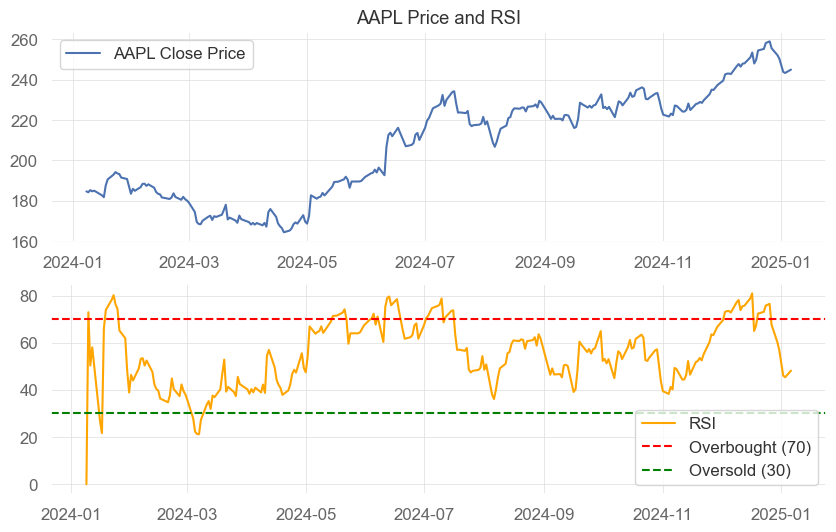

In [11]:
plt.subplot(2, 1, 1)
plt.plot(data['Close'], label=f'{ticker} Close Price')
plt.title(f'{ticker} Price and RSI')
plt.legend()
    
plt.subplot(2, 1, 2)
plt.plot(data['RSI'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.legend()
plt.show()

In [16]:
data.drop(columns = ['Signal'], inplace =True)

In [20]:
data.drop(columns = ['RSI'], inplace = True)

# RSI BASED MOMENTUM

In [35]:
class RSI_Strategy(bt.Strategy):
    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close , period = 14)
        self.position_flag = 0
        
    def next(self):
        if self.rsi < 30 and self.position.size == 0:  # Buy signal and no current position
            # Calculate how many shares you can buy with 90% of your cash
            size = int(self.broker.cash * 0.9 / self.data.close[0])
            if size > 0:
                self.buy(size=size)  # Specify the size explicitly
    
        elif self.rsi > 70 and self.position.size > 0:  # Sell signal and a position exists
            self.sell(size=self.position.size)  # Sell all shares

In [36]:
data_feed = bt.feeds.PandasData(dataname = data)

In [37]:
cerebro = bt.Cerebro()

cerebro.adddata(data_feed)
cerebro.addstrategy(RSI_Strategy)

cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.001)  # Commission per trade
cerebro.run()

<IPython.core.display.Javascript object>

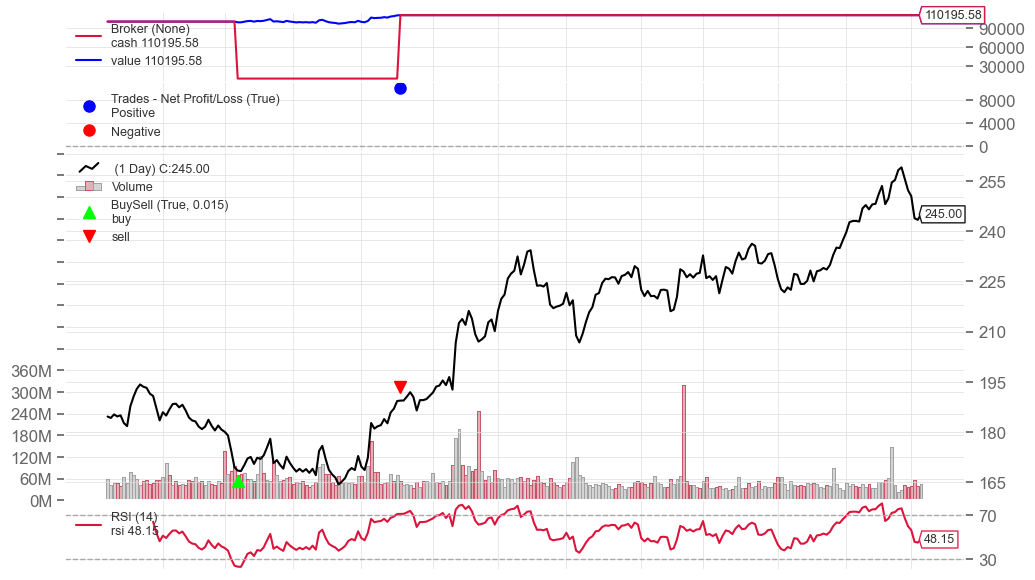

In [38]:
%matplotlib inline
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
cerebro.plot()
plt.show()

In [39]:
final_cash = cerebro.broker.get_cash()
print(f"Final value : {final_cash}")

Final value : 110195.5825712494


# MACD BASED


MACD consists of three key elements:

MACD Line:

This is the difference between two Exponential Moving Averages (EMAs):
- A short-term EMA (commonly 12-period).
- A long-term EMA (commonly 26-period).

Formula:

MACD Line = EMA(12) − EMA(26)
It shows the relationship between short-term and long-term price momentum.

Signal Line:

A 9-period EMA of the MACD Line.
This line acts as a smoothing factor and is used to identify potential entry and exit points by comparing it to the MACD Line.
Histogram:

The difference between the MACD Line and the Signal Line.

Formula: 
Histogram =  MACD Line − Signal Line

The histogram visually represents the strength of the momentum.
- A positive histogram means the MACD Line is above the Signal Line (bullish).
- A negative histogram means the MACD Line is below the Signal Line (bearish).

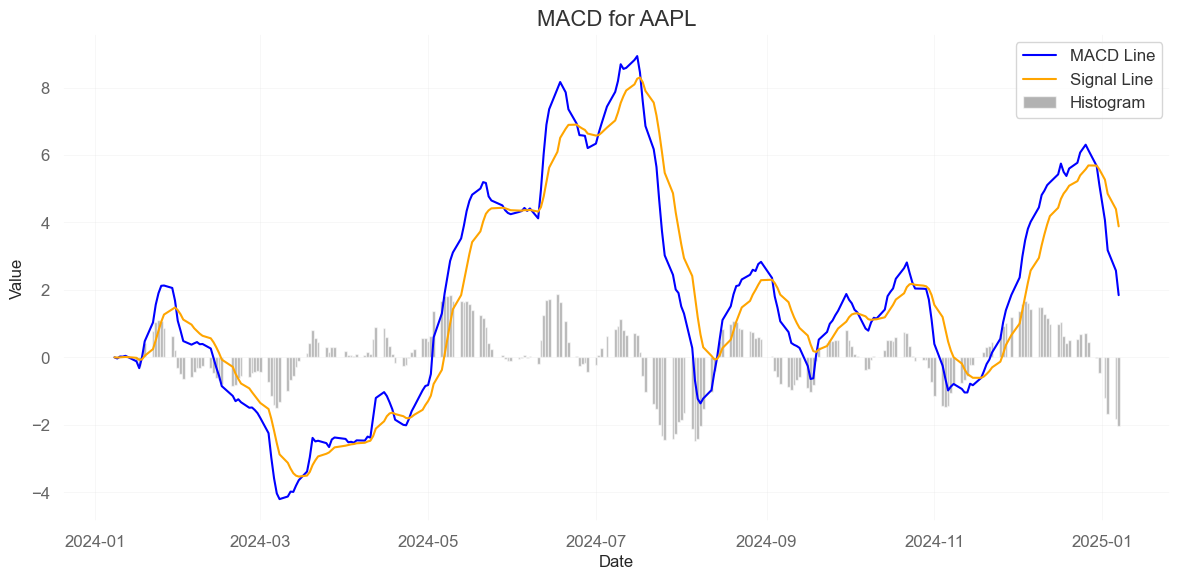

In [4]:
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # Short-term EMA (fast)
    data['EMA_12'] = data['Close'].ewm(span=short_period, adjust=False).mean()
    # Long-term EMA (slow)
    data['EMA_26'] = data['Close'].ewm(span=long_period, adjust=False).mean()
    # MACD Line
    data['MACD_Line'] = data['EMA_12'] - data['EMA_26']
    # Signal Line
    data['Signal_Line'] = data['MACD_Line'].ewm(span=signal_period, adjust=False).mean()
    # Histogram (MACD Line - Signal Line)
    data['Histogram'] = data['MACD_Line'] - data['Signal_Line']
    return data

# Calculate MACD
data = calculate_macd(data)

# Plot the MACD, Signal Line, and Histogram
plt.figure(figsize=(12, 6))

# Plot MACD Line and Signal Line
plt.plot(data['MACD_Line'], label='MACD Line', color='blue', linewidth=1.5)
plt.plot(data['Signal_Line'], label='Signal Line', color='orange', linewidth=1.5)

# Plot the Histogram as bars
plt.bar(data.index, data['Histogram'], label='Histogram', color='gray', width=1.0, alpha=0.6)

# Formatting the chart
plt.title(f"MACD for {ticker}", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
data.drop(columns=['EMA_12','EMA_26','MACD_Line','Signal_Line','Histogram'] , inplace = True)

In [10]:
class MACD_Strategy(bt.Strategy):
    def __init__(self) :
        self.macd = bt.indicators.MACD(self.data.close , period_me1 = 12 , period_me2 = 26 , period_signal = 9 )
        self.position_flag = 0

    def next(self):
        if self.macd.macd > self.macd.signal and self.position_flag == 0:
            self.buy()
            self.position_flag = 1
            print(f"BUY: {self.data.datetime.date(0)} at price {self.data.close[0]:.2f}")
        elif self.macd.macd < self.macd.signal and self.position_flag == 1:
            self.sell()
            self.position_flag = 0
            print(f"SELL: {self.data.datetime.date(0)} at price {self.data.close[0]:.2f}")

In [13]:
data_feed = bt.feeds.PandasData(dataname=data)

# Set up Backtrader's Cerebro engine
cerebro = bt.Cerebro()

# Add the data feed
cerebro.adddata(data_feed)

# Add the MACD strategy
cerebro.addstrategy(MACD_Strategy)

# Set the initial cash
cerebro.broker.setcash(100000)  # Starting capital

# Set the commission
cerebro.broker.setcommission(commission=0.001)  # 0.1% commission per trade

# Run the backtest
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.run()
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Starting Portfolio Value: 100000.00
BUY: 2024-03-18 at price 173.09
SELL: 2024-04-19 at price 164.41
BUY: 2024-04-25 at price 169.28
SELL: 2024-05-29 at price 189.86
BUY: 2024-06-05 at price 195.43
SELL: 2024-06-06 at price 194.04
BUY: 2024-06-07 at price 196.45
SELL: 2024-06-10 at price 192.68
BUY: 2024-06-11 at price 206.68
SELL: 2024-06-25 at price 208.60
BUY: 2024-07-02 at price 219.77
SELL: 2024-07-18 at price 223.67
BUY: 2024-08-14 at price 221.48
SELL: 2024-09-04 at price 220.61
BUY: 2024-09-20 at price 227.95
SELL: 2024-10-07 at price 221.45
BUY: 2024-10-10 at price 228.79
SELL: 2024-10-25 at price 231.16
BUY: 2024-11-19 at price 228.28
SELL: 2024-12-30 at price 252.20
Final Portfolio Value: 100035.14


<IPython.core.display.Javascript object>

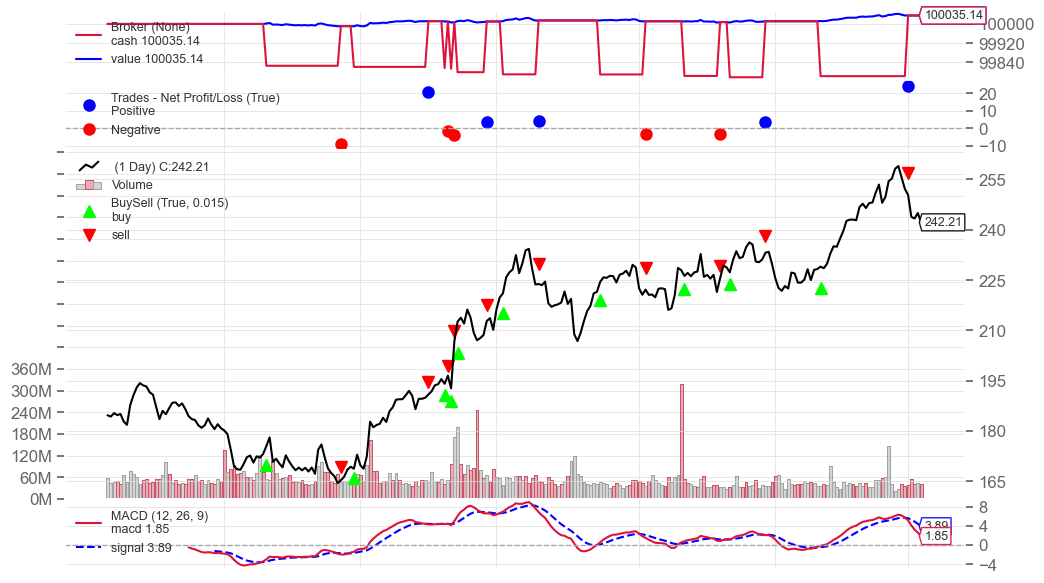

In [12]:
%matplotlib inline
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
cerebro.plot()
plt.show()

# ROC

Rate of Change (ROC) is a momentum-based technical indicator that measures the percentage change in price between the current price and a price from a previous period. It helps identify the strength of price movements and is often used for spotting overbought or oversold conditions.


In [3]:
roc_period = 14  # You can adjust the period for ROC calculation
data['ROC'] = ((data['Close'] - data['Close'].shift(roc_period)) / data['Close'].shift(roc_period)) * 100

In [4]:
data

Price,Close,High,Low,Open,Volume,ROC
Date,,,,,,
2024-01-08,184.655365,184.695178,180.615161,181.202281,59144500,NaN
2024-01-09,184.237411,184.247357,181.839157,183.023358,42841800,NaN
2024-01-10,185.282288,185.491255,183.023350,183.451262,46792900,NaN
2024-01-11,184.685226,186.138115,182.724829,185.630592,49128400,NaN
2024-01-12,185.013611,185.829621,184.287174,185.152928,40444700,NaN
...,...,...,...,...,...,...
2024-12-31,250.419998,253.279999,249.429993,252.440002,39480700,1.069538
2025-01-02,243.850006,249.100006,241.820007,248.929993,55740700,-1.071037
2025-01-03,243.360001,244.179993,241.889999,243.360001,40244100,-1.855140


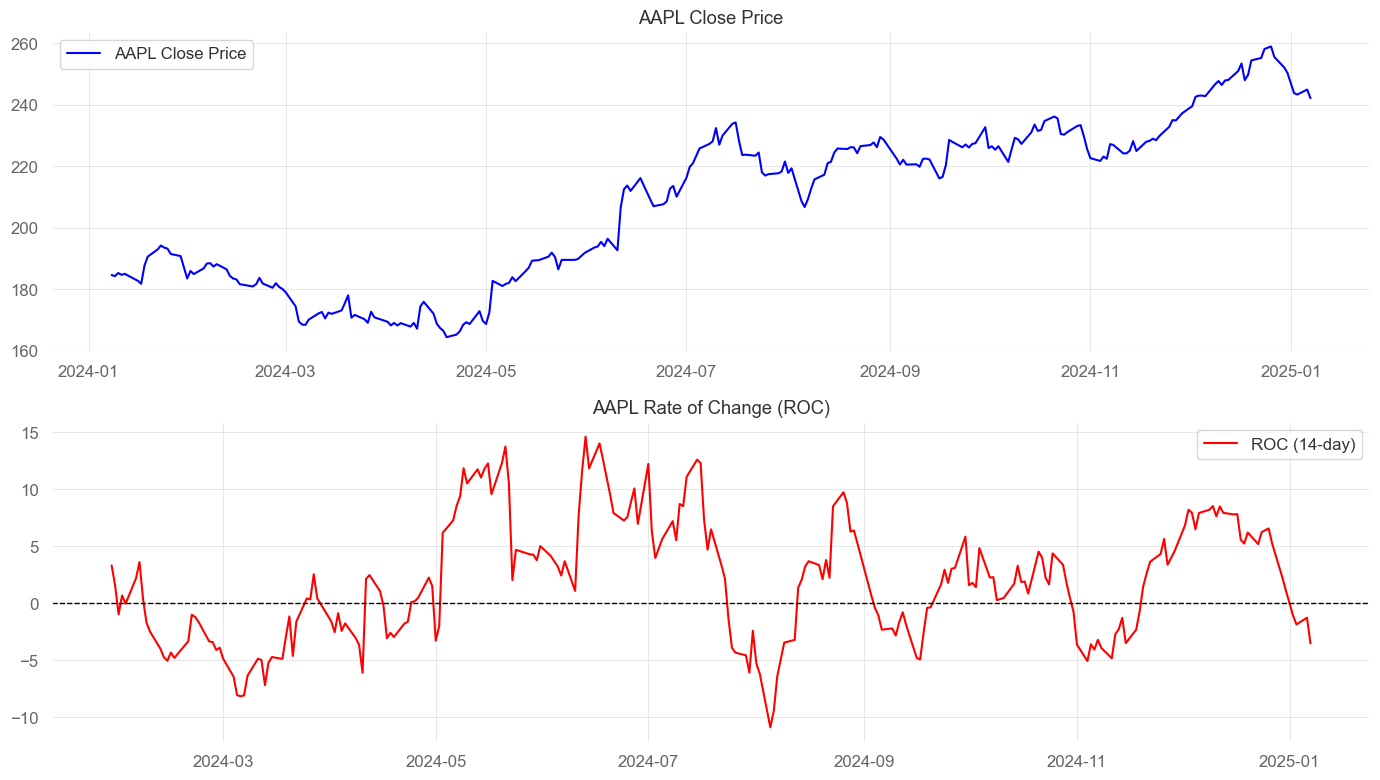

In [5]:
# Plot the closing price and ROC
plt.figure(figsize=(14, 8))

# Plotting the closing price
plt.subplot(2, 1, 1)
plt.plot(data['Close'], label=f'{ticker} Close Price', color='blue')
plt.title(f'{ticker} Close Price')
plt.legend(loc='best')

# Plotting the ROC
plt.subplot(2, 1, 2)
plt.plot(data['ROC'], label='ROC (14-day)', color='red')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Zero line for ROC
plt.title(f'{ticker} Rate of Change (ROC)')
plt.legend(loc='best')

# Show plots
plt.tight_layout()
plt.show()

In [7]:
data.drop(columns=['ROC'] , inplace = True)

In [6]:
class ROC_Strategy(bt.Strategy):

    def __init__(self):
        self.roc = bt.indicators.RateOfChange(self.data.close, period=14)
        self.position_flag = 0 

    def next(self):
        # Check for a buy signal
        if self.roc > 0 and self.position_flag == 0:  
            self.buy()  # Execute buy order
            self.position_flag = 1  # Update the position flag to indicate a position is open
            print(f"BUY: {self.data.datetime.date(0)} at price {self.data.close[0]:.2f}")

        # Check for a sell signal
        elif self.roc < 0 and self.position_flag == 1:  # ROC < 0 and position is open
            self.sell()  # Execute sell order
            self.position_flag = 0  # Update the position flag to indicate no position is open
            print(f"SELL: {self.data.datetime.date(0)} at price {self.data.close[0]:.2f}")


In [7]:
data_feed = bt.feeds.PandasData(dataname=data)

# Set up Backtrader's Cerebro engine
cerebro = bt.Cerebro()

# Add the data feed
cerebro.adddata(data_feed)
cerebro.addstrategy(ROC_Strategy)

# Set the initial cash
cerebro.broker.setcash(100000)  # Starting capital

# Set the commission
cerebro.broker.setcommission(commission=0.001)  # 0.1% commission per trade

# Run the backtest
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.run()
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Starting Portfolio Value: 100000.00
BUY: 2024-01-30 at price 187.12
SELL: 2024-01-31 at price 183.50
BUY: 2024-02-01 at price 185.95
SELL: 2024-02-02 at price 184.94
BUY: 2024-02-05 at price 186.77
SELL: 2024-02-08 at price 187.40
BUY: 2024-03-25 at price 170.23
SELL: 2024-04-01 at price 169.42
BUY: 2024-04-11 at price 174.41
SELL: 2024-04-16 at price 168.77
BUY: 2024-04-24 at price 168.41
SELL: 2024-05-01 at price 168.69
BUY: 2024-05-03 at price 182.72
SELL: 2024-07-24 at price 218.05
BUY: 2024-08-13 at price 221.03
SELL: 2024-09-04 at price 220.61
BUY: 2024-09-23 at price 226.22
SELL: 2024-10-31 at price 225.66
BUY: 2024-11-20 at price 229.00
SELL: 2025-01-02 at price 243.85
Final Portfolio Value: 100045.37


<IPython.core.display.Javascript object>

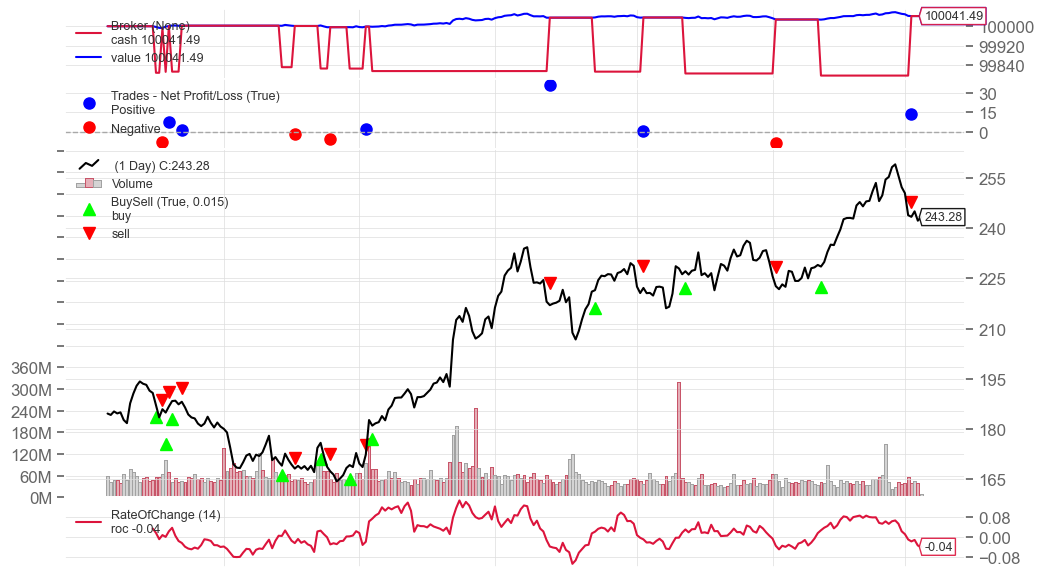

In [8]:
%matplotlib inline
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
cerebro.plot()
plt.show()

# Momentum Oscillator
A Momentum Oscillator is a technical analysis tool that measures the rate of change of a financial instrument's price over a specified period. It is used to determine the strength of price movements and potential reversals in the market.

The oscillator fluctuates between positive and negative values, typically oscillating around a central point (usually 0) without being bounded to a fixed range. It helps traders identify whether a market is gaining momentum (trend continuation) or losing momentum (potential reversal).

Formula:

Momentum Oscillator = (Current Price - Price (N) periods ago) / Price (N) periods ago

### How to Interpret Momentum Oscillator Data?
1. Positive Momentum:
When the Momentum Oscillator is above 0, it indicates that the price is moving upward compared to the past N periods.
Higher positive values suggest increasing bullish momentum.

2. Negative Momentum:
When the Momentum Oscillator is below 0, it indicates that the price is moving downward compared to the past N periods.
Lower negative values suggest increasing bearish momentum.

3. Crossing Zero:
    - Bullish Signal: When the oscillator crosses above 0, it suggests a potential upward trend.
    - Bearish Signal: When the oscillator crosses below 0, it suggests a potential downward trend.

4. Magnitude of Oscillation:
    - Larger values (positive or negative) represent stronger price movements and higher momentum.
    - Smaller values (close to 0) indicate weakening momentum or a range-bound market.

In [8]:
class MO_Strategy(bt.Strategy):

    def __init__(self):
        self.mo = (self.data.close - self.data.close[-14])/ self.data.close[-14]
        self.position_flag = 0

    def next(self):
        if self.mo[0] > 0 and self.position_flag == 0:
            self.buy()
            self.position_flag = 1
            print(f"BUY: {self.data.datetime.date(0)} at price {self.data.close[0]:.2f}")
            
        elif self.mo[0] < 0 and self.position_flag == 1:
            self.sell()
            self.position_flag = 0
            print(f"SELL: {self.data.datetime.date(0)} at price {self.data.close[0]:.2f}")

In [12]:
data_feed = bt.feeds.PandasData(dataname=data)

# Set up Backtrader's Cerebro engine
cerebro = bt.Cerebro()

# Add the data feed
cerebro.adddata(data_feed)
cerebro.addstrategy(MO_Strategy)

# Set the initial cash
cerebro.broker.setcash(100000)  # Starting capital

# Set the commission
cerebro.broker.setcommission(commission=0.001)  # 0.1% commission per trade

# Run the backtest
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.run()
final_cash = cerebro.broker.getvalue()
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Starting Portfolio Value: 100000.00
BUY: 2024-12-20 at price 254.49
SELL: 2024-12-30 at price 252.20
Final Portfolio Value: 99997.16


# CAGR (Compound Annual Growth Rate)

Annual Growth rate of portfolio over backtesting period.


In [5]:
years = (data.index[-1] - data.index[0]).days/365.25
years

0.999315537303217

In [13]:
cagr = (final_cash/100000)**(1/years)-1
cagr

-2.8391551059603337e-05

In [14]:
def cagr(final_cash, initial_cash,data):
    years = (data.index[-1] - data.index[0]).days/365.25
    cagr = (final_cash/100000)**(1/years)-1
    return cagr

## Other Metrics include:

### 1. Sharpe Value:
    - The Sharpe Ratio is a measure of risk-adjusted returns. It tells us how much return a portfolio generates for each unit of risk (volatility) taken. A higher Sharpe Ratio is better, as it indicates that the strategy is generating more return for the amount of risk it is taking.

### 2.  Maximum Drawdown:
    - Maximum Drawdown (MDD) is a measure of the largest peak-to-trough decline in the value of a portfolio during a specific period. It helps you assess the risk of significant losses in your portfolio.
    - **Peak Portfolio Value**: The highest portfolio value at a point in time. **Trough Portfolio Value**: The lowest portfolio value after the peak, before a new peak is reached.
    - (ppv - tpv)/ ppv 